# Regression and Prediction

The most common goal in statistic is to answer the question "Is the variable $X\in\R^p$ associated with a variable $Y\in\R^q$, and if so, what is the relationship and can we us it to predict Y?"

In [33]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns
import matplotlib.pyplot as plt

from pygam import LinearGAM, s, l
from pygam.datasets import wage

%matplotlib inline

In [34]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [35]:
LUNG_CSV = DATA / 'LungDisease.csv'
HOUSE_CSV = DATA / 'house_sales.csv'

## Simple Linear Regression
Important key terms: 
- **Response**
- **Independent variable**
- **Record**
- **Intercept**
- **Regression coefficient**
- **Fitted values**
- **Residuals**
- **Least squares**(sensitive to outliers)

In [36]:
lung = pd.read_csv(LUNG_CSV)
lung.head()

,PEFR,Exposure
0,390,0
1,410,0
2,430,0
3,460,0
4,420,1


### Plotting scatter plot cotton exposure versus lung capacity

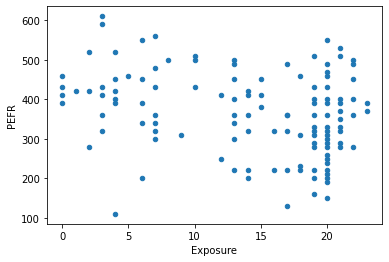

In [37]:
ax = lung.plot.scatter(x='Exposure', y='PEFR')
plt.show()

### Compute regression line intercept and coefficient

In [38]:
predictors = ['Exposure']
outcome = 'PEFR'
model = LinearRegression()
model.fit(lung[predictors], lung[outcome])
print('Intercept: {:.3f}'.format(model.intercept_))
print('Coefficient Exposure: {:.3f}'.format(model.coef_[0]))

Intercept: 424.583
Coefficient Exposure: -4.185


In [39]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

### Plotting residuals from a regression line

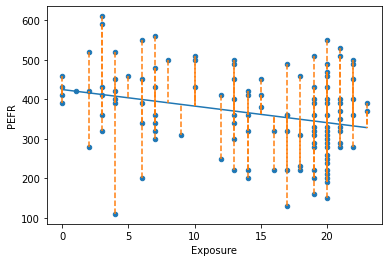

In [40]:
ax = lung.plot.scatter(x='Exposure', y='PEFR')
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted):
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.show()


## Prediction Versus Explanation (Profiling)
Note that conclusions about causation must come from a broader understanding about relationship. For example, a regression equation might show a definite relationship between number of clicks on a web ad and number of conversions. It is our konwledge of the marketing process, not the regression equation, that leads us to the conclusion that clicks on the ad lead to sales, and not vice versa.

## Multiple Linear Regression
Important key terms: 
- **Root mean squared error**
- **Residual standard error**
- **R-squared**
- **t-statistic**(coefficient divided by standard error of coefficient gives a metric to compare the importance of variables in the model.)
- **Weighted regression**

### Example: King County Housing Data

In [41]:
house = pd.read_csv(HOUSE_CSV, sep='\t')
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


In [42]:
house.columns

Index(['DocumentDate', 'SalePrice', 'PropertyID', 'PropertyType', 'ym',
       'zhvi_px', 'zhvi_idx', 'AdjSalePrice', 'NbrLivingUnits', 'SqFtLot',
       'SqFtTotLiving', 'SqFtFinBasement', 'Bathrooms', 'Bedrooms',
       'BldgGrade', 'YrBuilt', 'YrRenovated', 'TrafficNoise', 'LandVal',
       'ImpsVal', 'ZipCode', 'NewConstruction'],
      dtype='object')

In [43]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
house[subset].head()

,AdjSalePrice,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
1,300805.0,2400,9373,3.00,6,7
2,1076162.0,3764,20156,3.75,4,10
3,761805.0,2060,26036,1.75,4,8
4,442065.0,3200,8618,3.75,5,7
5,297065.0,1720,8620,1.75,4,7


In [44]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

LinearRegression()

In [45]:
print('Intercept: {:.3f}'.format(house_lm.intercept_))
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print('{}: {}'.format(name, coef))

Intercept: -521871.368
Coefficients:
SqFtTotLiving: 228.83060360240796
SqFtLot: -0.06046682065307607
Bathrooms: -19442.840398321056
Bedrooms: -47769.95518521438
BldgGrade: 106106.96307898083


Note: adding an extra finished square foot to a house increases the estimated value by roughly \$229; adding 1,000 finished square feet implies the value will increase by \$228,800.

## Assessing the Model
The most important performance metric from a data science perspective is root mean squared error, or RMSE:
$$
RMSE = \sqrt{\frac{\sum_{i=1}^n (y_i-\hat{y_i})^2}{n}}
$$

Similar to RMSE is the residual standard error, or RSE. In this case we have p predictors, and the RSE is given by:
$$
RSE = \sqrt{\frac{\sum_{i=1}^n (y_i-\hat{y_i})^2}{n-p-1}}
$$

The diffence between RMSE and RSE is very small, particularly for big data applications.

### Compute mean_squared_error to get RMSE and r2_score for the coefficient of detemination

In [46]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print('RMSE: {:0f}'.format(RMSE))
print('r2: {:0f}'.format(r2))

RMSE: 261220.197437
r2: 0.540588


### Get a more detailed analysis of the regressoin model

In [47]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:00:49   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694      0.000     221.189     236.472
SqFtLot          -0.0605      0.061     -0.988      0.323      -0.180       0.059
Bathrooms     -1.944e+04   3625.388     -5.363      0.000   -2.65e+04   -1.23e+04
Bedrooms      -4.777e+04   2489.732    -19.187      0.000   -5.27e+04   -4.29e+04
BldgGrade      1.061e+05   2396.445     44.277      0.000    1.01e+05    1.11e+05
const         -5.219e+05   1.57e+04    -33.342      0.000   -5.53e+05   -4.91e+05
==============================================================================
Omnibus:                    29676.557   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19390738.346
Skew:                           6.889   Prob(JB):                         0.00
Kurtosis:                     145.559   Cond. No.                     2.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that Data Scientist not generally get too involved with the interpretation of the F-statistic, nor with the issure of statistical significance. They are mostly focused on the t-statitistic as a useful guide for whether to include a predictor in a model or not.

## Cross-Validation
Classical statistical regression metrics($R^2$, F-statistics, and p-value) are all 'in-sample' metrics-they are applied to the same data that was used to fit the model. Normally, we would use a majority of the data to fit the model and use a smaller portion to test the model. Furthermore, cross-validation extends the idea of a holdout sample to multiple sequential holdout samples. Recall k-fold cross-validation.

## Model Selection and Stepwise Regression

Note in python we need to convert categorical and booliean variables into numbers:

In [48]:
house['NewConstruction'].head()

1    False
2     True
3    False
4    False
5    False
Name: NewConstruction, dtype: bool

In [49]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade', 
              'PropertyType', 'NbrLivingUnits', 'SqFtFinBasement', 'YrBuilt', 
              'YrRenovated', 'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)

In [50]:
X.head()

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,NbrLivingUnits,SqFtFinBasement,YrBuilt,YrRenovated,NewConstruction,PropertyType_Single Family,PropertyType_Townhouse
1,2400,9373,3.00,6,7,2,0,1991,0,False,0,0
2,3764,20156,3.75,4,10,1,1452,2005,0,True,1,0
3,2060,26036,1.75,4,8,1,900,1947,0,False,1,0
4,3200,8618,3.75,5,7,1,1640,1966,0,False,1,0
5,1720,8620,1.75,4,7,1,0,1948,0,False,1,0


In [51]:
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

In [52]:
house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:00:50   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving                198.6364      4.234     46.920      0.000     190.338     206.934
SqFtLot                        0.0771      0.058      1.330      0.184      -0.037       0.191
Bathrooms                   4.286e+04   3808.114     11.255      0.000    3.54e+04    5.03e+04
Bedrooms                   -5.187e+04   2396.904    -21.638      0.000   -5.66e+04   -4.72e+04
BldgGrade                   1.373e+05   2441.242     56.228      0.000    1.32e+05    1.42e+05
NbrLivingUnits              5723.8438   1.76e+04      0.326      0.744   -2.87e+04    4.01e+04
SqFtFinBasement                7.0611      4.627      1.526      0.127      -2.009      16.131
YrBuilt                    -3574.2210     77.228    -46.282      0.000   -3725.593   -3422.849
YrRenovated                   -2.5311      3.924     -0.645      0.519     -10.222       5.160
NewConstruction            -2489.1122   5936.692     -0.419      0.675   -1.41e+04    9147.211
PropertyType_Single Family  2.997e+04   2.61e+04      1.149      0.251   -2.12e+04    8.11e+04
PropertyType_Townhouse      9.286e+04    2.7e+04      3.438      0.001    3.99e+04    1.46e+05
const                       6.182e+06   1.55e+05     39.902      0.000    5.88e+06    6.49e+06
==============================================================================
Omnibus:                    31006.128   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26251977.078
Skew:                           7.427   Prob(JB):                         0.00
Kurtosis:                     168.984   Cond. No.                     2.98e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

How do we find the model that minimized AIC or maximizes adjusted $R^2$. An attractive alternative is to use stepwise regression. It could start with a constant model and successively add variables(forward selection). Another selection can be successively add and drop predictors to find a model that lowers AIC or adjusted $R^2$.

**Note:**

Scikit-learn indeed does not support stepwise regression. That's because what is commonly known as 'stepwise regression' is an algorithm based on p-values of coefficients of linear regression, and scikit-learn deliberately avoids inferential approach to model learning (significance testing etc). Moreover, pure OLS is only one of numerous regression algorithms, and from the scikit-learn point of view it is neither very important, nor one of the best.

There are, however, some pieces of advice for those who still need a good way for feature selection with linear models:

1. Use inherently sparse models like ElasticNet or Lasso.
2. Normalize your features with StandardScaler, and then order your features just by model.coef_. For perfectly independent covariates it is equivalent to sorting by p-values. The class sklearn.feature_selection.RFE will do it for you, and RFECV will even evaluate the optimal number of features.
3. Use [an implementation][1] of forward selection by adjusted $R^2$ that works with statsmodels.
4. Do brute-force forward or backward selection to maximize your favorite metric on cross-validation (it could take approximately quadratic time in number of covariates). A scikit-learn compatible mlxtend package [supports][2] this approach for any estimator and any metric.
5. If you still want vanilla stepwise regression, it is easier to base it on statsmodels, since this package calculates p-values for you. A basic forward-backward selection could look like this:

In [53]:
def stepwise_selection(X, y, initial_list=[], 
                             threshold_in=0.01, 
                             threshold_out = 0.01, 
                             verbose=True):
        """ Perform a forward-backward feature selection 
        based on p-value from statsmodels.api.OLS
        Arguments:
            X - pandas.DataFrame with candidate features
            y - list-like with the target
            initial_list - list of features to start with (column names of X)
            threshold_in - include a feature if its p-value < threshold_in
            threshold_out - exclude a feature if its p-value > threshold_out
            verbose - whether to print the sequence of inclusions and exclusions
        Returns: list of selected features 
        Always set threshold_in < threshold_out to avoid infinite looping.
        See https://en.wikipedia.org/wiki/Stepwise_regression for the details
        """
        included = list(initial_list)
        while True:
            changed=False
            # forward step
            excluded = list(set(X.columns)-set(included))
            new_pval = pd.Series(index=excluded, dtype='float64')
            for new_column in excluded:
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
                new_pval[new_column] = model.pvalues[new_column]
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

            # backward step
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            # use all coefs except intercept
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max() # null if pvalues is empty
            if worst_pval > threshold_out:
                changed=True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
            if not changed:
                break
        return included

result = stepwise_selection(X, house[outcome])

print('resulting features:')
print(result)

Add  SqFtTotLiving                  with p-value 0.0
Add  BldgGrade                      with p-value 0.0
Add  YrBuilt                        with p-value 0.0
Add  Bedrooms                       with p-value 1.93501e-99


Add  Bathrooms                      with p-value 6.834e-42
Add  PropertyType_Townhouse         with p-value 7.89466e-19
resulting features:
['SqFtTotLiving', 'BldgGrade', 'YrBuilt', 'Bedrooms', 'Bathrooms', 'PropertyType_Townhouse']


Note that stepwise regression and all subset regression are in-sample methods to assess and tune models. This may lead to overfit but the model is linear so it typically  not a major issue.

## Weighted Regression
Data sciestist may findd weighted regression useful in two cases:
- Inverse-variance weighting when different observations have been measured with different precision; the higher variance ones recieving lower weights.
- Analyst of data where rows represent multiple cases; the weight variable encodes how many original observations each row represents.

### Example with housing data
Older sales are less reliable than more recent sales. Using the DocumentDate to determine the year of the sale, we can compute a weight as the number of years since 2005

In [54]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Weight'] = house.Year - 2005

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)

LinearRegression()

In [55]:
pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,
    })
])

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


The coefficients in the weighted regression are slightly different from the original regression.

## Prediction Using Regression
Important key terms: 
- **Prediction interval**(different between confidence interal, remember!)
- **Extrapolation**

Note that regression models should not be used to extrapolate beyond the range of the data(leaving aside the use of regression for time series forecasting.). For example using `house_lm` a 5000sq-ft empty lot yeilds a prediction of -521,871+5000*(-.0605) $\approx$ -\$522,200. The model has no info to tell it how to predict the sales price for vacant land. Data scientist are also concerned with intervals around predicted y values. The uncertainty around y comes from the two sources.
- Uncertainty about what the relevant predictor variables and their coefficients.
- Additional error inherent in individual data points

## Factor Variable in Regression
Important key terms:
- **Dummy variables**
- **Reference coding**
- **One hot encoder**
- **Deviation coding**

In [56]:
house.PropertyType.head()

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object

### Convert categorical variables to dummies

In [57]:
pd.get_dummies(house['PropertyType']).head() 

,Multiplex,Single Family,Townhouse
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0


In [58]:
pd.get_dummies(house['PropertyType'], drop_first=True).head() # helps with multicollinearity

,Single Family,Townhouse
1,0,0
2,1,0
3,1,0
4,1,0
5,1,0


In [59]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503822
 SqFtLot: -0.0703679813681255
 Bathrooms: -15979.013473415183
 Bedrooms: -50889.73218483028
 BldgGrade: 109416.3051614618
 PropertyType_Single Family: -84678.21629549256
 PropertyType_Townhouse: -115121.97921609186


The coefficients are interpreted as relative to Multiplex, so a home that is Single Family is worth almost \$85000 less, and a home that is Townhouse is worth over \$150000 less.

## Factor Variables with Many Levels
Sometime there are to many values in a categorical variable (think zip code). One must explore the relationship with the outcome to see whether we should keep the variable or should levels be consolidated.

In [60]:
pd.DataFrame(house['ZipCode'].value_counts()).transpose()

,98038,98103,98042,98115,98117,98052,98034,98033,98059,98074,...,98051,98024,98354,98050,98057,98288,98224,98043,98068,98113
ZipCode,788,671,641,620,619,614,575,517,513,502,...,32,31,9,7,4,4,3,1,1,1


Zipcode is an inportant variable, since it is a proxy for the effect of location on the value of a house. Including all levels requires 79 coefficients allowing for 79 degrees of freedom and the original model only has 5 degrees of freedom. An alternative approach is to group the zip codes according to another variable, such as sales price. Even better is to form zip code groups using the residuals from an initial model.

In [61]:
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

LinearRegression()

In [62]:
zip_groups_list = list(pd.DataFrame({
'ZipCode': house['ZipCode'],
'residual': house[outcome] - house_lm.predict(house[predictors]),
    }).groupby(['ZipCode']).apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
}))

zip_groups = pd.DataFrame.from_records(zip_groups_list).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False)

In [63]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')
house[['ZipCode', 'ZipGroup']].head()

,ZipCode,ZipGroup
1,98002,2
2,98166,2
3,98166,2
4,98168,2
5,98168,2


## Ordered Factor Variables
some factor variables reflect levels of a factor. For example, loan grade could be A, B, C, and so on- each grade carries more risk than the prior grade. Treating the ordered factor as a numeric variable preserves the information contained in the ordering what would be lost if it we converted to a factor.

## Interpreting the Regression Equation
Important key terms:
- **Correlated variables**
- **Multicollinearity**(multiple variables, P instead of P-1 dummies, X, Y near perfect correlation)
- **Confounding variables**(omission of important variables)
- **Main effects**
- **Interations**

Having correlated predictors can make it difficult to interpret the sign and value of regression coefficients(and can inflate the standard error of the estimates.) For example, bedrooms, house size, and number of bathrooms are all correlated with could lead to negative coefficient in bedrooms(a negative impact on home price).

### Including interactions between variables in King County data

In [70]:
model = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving*ZipGroup + SqFtLot + ' + 
'Bathrooms + Bedrooms + BldgGrade + PropertyType', data = house)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:06:21   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -4.853e+05   2.05e+04    -23.701      0.000   -5.25e+05   -4.45e+05
ZipGroup[T.1]                 -1.113e+04   1.34e+04     -0.830      0.407   -3.74e+04    1.52e+04
ZipGroup[T.2]                  2.032e+04   1.18e+04      1.717      0.086   -2877.441    4.35e+04
ZipGroup[T.3]                   2.05e+04   1.21e+04      1.697      0.090   -3180.870    4.42e+04
ZipGroup[T.4]                 -1.499e+05   1.13e+04    -13.285      0.000   -1.72e+05   -1.28e+05
PropertyType[T.Single Family]  1.357e+04   1.39e+04      0.975      0.330   -1.37e+04    4.09e+04
PropertyType[T.Townhouse]     -5.884e+04   1.51e+04     -3.888      0.000   -8.85e+04   -2.92e+04
SqFtTotLiving                   114.7650      4.863     23.600      0.000     105.233     124.297
SqFtTotLiving:ZipGroup[T.1]      32.6043      5.712      5.708      0.000      21.409      43.799
SqFtTotLiving:ZipGroup[T.2]      41.7822      5.187      8.056      0.000      31.616      51.948
SqFtTotLiving:ZipGroup[T.3]      69.3415      5.619     12.341      0.000      58.329      80.354
SqFtTotLiving:ZipGroup[T.4]     226.6836      4.820     47.032      0.000     217.237     236.131
SqFtLot                           0.6869      0.052     13.296      0.000       0.586       0.788
Bathrooms                     -3619.4533   3202.296     -1.130      0.258   -9896.174    2657.267
Bedrooms                       -4.18e+04   2120.279    -19.715      0.000    -4.6e+04   -3.76e+04
BldgGrade                      1.047e+05   2069.472     50.592      0.000    1.01e+05    1.09e+05
==============================================================================
Omnibus:                    30927.394   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34361794.502
Skew:                           7.279   Prob(JB):                         0.00
Kurtosis:                     193.101   Cond. No.                     5.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Diagnostics
Important key terms:
- **Standardized residuals**(# of standard errors away from the regression line)
- **Outliers**
- **Influential value**
- **Leverage**
- **Non-normal residuals**
- **Heteroskedasticity**
- **Partial residual plots**

Note there is no statisitcal theory that seperates outliers from nonoutliers. Rather, there are (arbitrary) rules of thumb for how distant from the bulk of the data an observation needs to be in order to be called an outlier. (1.5*IQR) In regression the standardized residual is the metric that is typically used to determine whether a record is classified as an outlier.

In [74]:
house_98105 = house.loc[house['ZipCode']==98105, ]
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome],
                       house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
result_98105.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Wed, 02 Aug 2023   Prob (F-statistic):          1.69e-103
Time:                        13:43:22   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587      0.000     161.574     257.631
SqFtLot          38.9333      5.330      7.305      0.000      28.445      49.421
Bathrooms      2282.2641      2e+04      0.114      0.909    -3.7e+04    4.16e+04
Bedrooms      -2.632e+04   1.29e+04     -2.043      0.042   -5.17e+04    -973.867
BldgGrade        1.3e+05   1.52e+04      8.533      0.000       1e+05     1.6e+05
const         -7.725e+05   9.83e+04     -7.861      0.000   -9.66e+05   -5.79e+05
==============================================================================
Omnibus:                       82.127   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              586.561
Skew:                           0.859   Prob(JB):                    4.26e-128
Kurtosis:                       9.483   Cond. No.                     5.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analyze the residuals

In [75]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal
sresiduals.idxmin(), sresiduals.min()

(24333, -4.326731804078561)

In [77]:
result_98105.resid.loc[sresiduals.idxmin()]

-757753.6192115824

The biggest overestimate from the model is more than four standard errors above the regression line, corresponding to an overestimate of \$757,754.

In [76]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms           3
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


A house this size should not have a sales price \$119,748. It is clear that the sale involved only partial interest in the property. In this case, the outlier corresponds to a sale that is anomolous and should not be included in the regression. 